In [27]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# 1. Load the dataset

In [29]:
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [30]:
df['review'][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

# 2. Preprocessing

In [31]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d','',text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'https?://\S+|www\.\S+','',text)
    text = re.sub(r'<.*?>','',text)
    text = re.sub(r'@\w+','',text)
    text = re.sub(r'#(\w+)',r'\1',text)
    text = re.sub(r'\s',' ',text).strip()
    return text


In [32]:
def preprocessing(text):
  if text is pd.isna(text):
    return ""
  text = clean_text(text)
  tokens = word_tokenize(text) #words
  stop_words = set(stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(word) for word in tokens]
  return ' '.join(tokens)




In [33]:
df['review']= df['review'].apply(preprocessing)

# Visualization

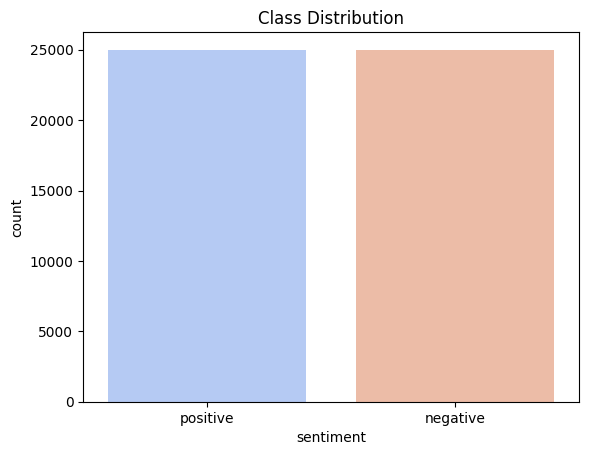

In [34]:
#class distribution
sns.countplot(data=df, x='sentiment', palette='coolwarm')
plt.title("Class Distribution")
plt.show()

In [35]:
#WordCloud
def generate_wordcloud(sentiment_label, dataframe):
    """Generates and displays a word cloud for a specific sentiment label."""
    text = ' '.join(dataframe[dataframe['sentiment'] == sentiment_label]['review'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Word Cloud for {sentiment_label} reviews')
    plt.tight_layout()
    plt.show()

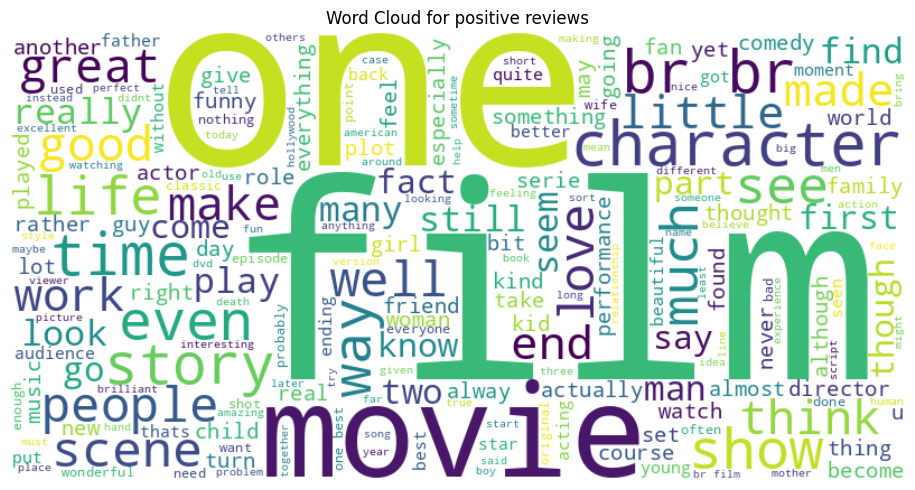

In [36]:
# Generate word cloud for positive reviews
generate_wordcloud('positive', df)

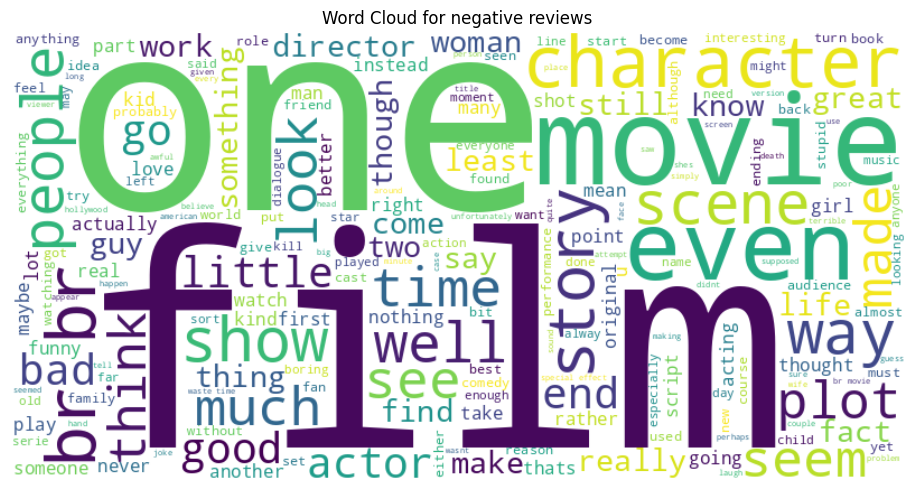

In [37]:
# Generate word cloud for negative reviews
generate_wordcloud('negative', df)

# Splitting data and Training

In [38]:
#ٌencoding
label_map = {'positive': 1, 'negative': 0}
df['label'] = df['sentiment'].map(label_map)

In [39]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['label'], test_size=0.2, random_state=42)

In [49]:
#Build pipeline with TF-IDF + Naive Bayes
model = Pipeline([
    ('tfidf', TfidfVectorizer( max_df=0.9, min_df=5,
    ngram_range=(1,3),  # 1-gram و 2-gram
    stop_words='english')),

    ('nb', MultinomialNB(alpha=0.5))
])

In [50]:
# Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores: ", cv_scores)
print("Average CV accuracy: ", np.mean(cv_scores))

Cross-validation scores:  [0.87375  0.879125 0.880625 0.872625 0.874375]
Average CV accuracy:  0.8760999999999999


In [51]:
# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=(1, 3),
                                 stop_words='english')),
                ('nb', MultinomialNB(alpha=0.5))])

In [52]:
# Evaluate the model
y_pred = model.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.8798

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88      4961
           1       0.88      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


Confusion Matrix:
 [[4332  629]
 [ 573 4466]]


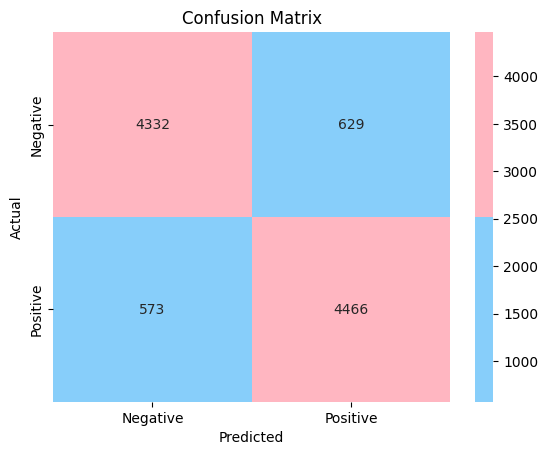

In [53]:
#Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=sns.color_palette(["#87CEFA", "#FFB6C1"]), xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [54]:
import joblib

# Save the trained model
joblib.dump(model, 'sentiment_model.pkl')

['sentiment_model.pkl']